# Time series forecasting with DeepAR - Telecom data

## Introduction

Time series forecasasting with DeepAR is a supervised learning algorithm for forecasting scalar time series with Telecom data. This notebook demonstrates how to prepare a dataset of time series for training DeepAR with telecom Call Detail Record(CDR) data, classify Call Disconnect Reason and how to use the trained model for inference. The notebook uses a hybrid approach of Spark ML Random Forest Classifier and DeepAR.


In [1]:
%config IPCompleter.greedy=True

This demonstrates the use of sparkml RandomForestClassifier for classification and feeds as input to DeepAR for Time series Prediction

In [2]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from sagemaker import get_execution_role
import sagemaker_pyspark
import pandas as pd
import numpy as np

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()

def getCdrDataframe():
    cdr_start_loc = "<%CDRStartFile%>"
    cdr_stop_loc = "<%CDRStopFile%>"
    cdr_start_sample_loc = "<%CDRStartSampleFile%>"
    cdr_stop_sample_loc = "<%CDRStopSampleFile%>"
    
    df = spark.read.format("s3select").parquet(cdr_stop_sample_loc)
    df.createOrReplaceTempView("cdr")
    return df

getCdrDataframe()

def build_schema():
    """Build and return a schema to use for the sample data."""
    schema = StructType(
            [
                StructField("Accounting_ID", StringType(), True),
                StructField("Start_Time_MM_DD_YYYY", StringType(), True),
                StructField("Start_Time_HH_MM_SS_s", StringType(), True),
                StructField("Call_Service_Duration", StringType(), True),
                StructField("Call_Disconnect_Reason", StringType(), True),
                StructField("Calling_Number", StringType(), True),
                StructField("Called_Number", StringType(), True)
            ]
        )
    return schema

import matplotlib.pyplot as plt
dataDF = spark.sql("SELECT _c2,_c5,_c6,_c13,_c14,_c19,_c20 from cdr where _c0 = 'STOP'")
dataPanda = dataDF.toPandas()
newDataDF = spark.createDataFrame(dataPanda.dropna(),build_schema())
dataPd = newDataDF.toPandas()

integerColumns = ["Call_Service_Duration" , "Call_Disconnect_Reason", "Calling_Number", "Called_Number"]
for col in integerColumns:
    dataPd[col] = dataPd[col].astype(int)
    
#Mock Data
def mock_data():
    from pyspark.sql.functions import rand,when
    addDF = newDataDF
    unionDF = addDF.union(newDataDF)
    df = unionDF.drop('Call_Disconnect_Reason')  
    df1 = df.withColumn('Call_Disconnect_Reason', when(rand(seed=1234) > 0.5, 16).otherwise(17))         
    return df1

df1 = mock_data()    
    
    
from pyspark.sql.functions import rand

trainingFraction = 0.75; testingFraction = (1-trainingFraction);
seed = 1234;
trainData, testData = df1.randomSplit([trainingFraction, testingFraction], seed=seed);

# # CACHE TRAIN AND TEST DATA
trainData.cache()
testData.cache()
trainData.count(),testData.count()

from pyspark.ml.feature import StringIndexer
columns_list = list(set(newDataDF.columns)-set(['Call_Disconnect_Reason']) ) 
indexers = []
for column in columns_list:
    indexer = StringIndexer(inputCol=column, outputCol=column+"_index")
    indexer.setHandleInvalid("skip")
    indexers.append(indexer)

from pyspark.ml.feature import StringIndexer
# Convert target into numerical categories
labelIndexer = StringIndexer(inputCol="Call_Disconnect_Reason", outputCol="label")
labelIndexer.setHandleInvalid("skip")
   
from pyspark.ml.feature import VectorAssembler
from array import array

inputcolsIndexer = []
for col in columns_list:
    inputcolsIndexer.append(col+"_index")
print(inputcolsIndexer)

vecAssembler = VectorAssembler(inputCols=inputcolsIndexer, outputCol="features")

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=8, maxBins=2400000, numTrees=128,impurity="gini")

from pyspark.ml.feature import ChiSqSelector
chisqSelector = ChiSqSelector(numTopFeatures=3, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="label")

from pyspark.ml import Pipeline
stages = []
stages += indexers 
stages += [labelIndexer]
stages += [vecAssembler]
stages += [rf]
stages += [chisqSelector]

pipeline = Pipeline(stages=stages)


['Start_Time_HH_MM_SS_s_index', 'Called_Number_index', 'Call_Service_Duration_index', 'Accounting_ID_index', 'Calling_Number_index', 'Start_Time_MM_DD_YYYY_index']


In [3]:
trainData.count(),testData.count()

(33607, 11219)

In [4]:
train_sdata = trainData.sample(False,0.1)
test_sdata = testData.sample(False,0.4)
train_sdata.count(),test_sdata.count()

(3403, 4487)

In [5]:
%time
model = pipeline.fit(train_sdata)
predictions = model.transform(test_sdata)
predictions.createOrReplaceTempView("predicted_table")
predictions.count()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs


356

In [6]:
predictions.show(2)

+------------------+---------------------+---------------------+---------------------+--------------+-------------+----------------------+---------------------------+-------------------+---------------------------+-------------------+--------------------+---------------------------+-----+--------------------+--------------------+--------------------+----------+----------------+
|     Accounting_ID|Start_Time_MM_DD_YYYY|Start_Time_HH_MM_SS_s|Call_Service_Duration|Calling_Number|Called_Number|Call_Disconnect_Reason|Start_Time_HH_MM_SS_s_index|Called_Number_index|Call_Service_Duration_index|Accounting_ID_index|Calling_Number_index|Start_Time_MM_DD_YYYY_index|label|            features|       rawPrediction|         probability|prediction|selectedFeatures|
+------------------+---------------------+---------------------+---------------------+--------------+-------------+----------------------+---------------------------+-------------------+---------------------------+-------------------+----

- _Call Disconnect Reason prediction count is computed to classify Normal Call Clearing(16) records and non Normal Call Clearing records as anomalous._

In [7]:
pred_sql = spark.sql("Select Start_Time_MM_DD_YYYY,Start_Time_HH_MM_SS_s,Call_Disconnect_Reason,prediction, CASE WHEN Call_Disconnect_Reason = 16 AND prediction = 0.0 THEN 0 ELSE 1 END AS anomaly from predicted_table")
dft = pred_sql.toPandas()

In [8]:
import pandas as pd
#dataframetime
dft['Date']=dft['Start_Time_MM_DD_YYYY'].astype(str)+' '+dft['Start_Time_HH_MM_SS_s']
dft['Date'] = pd.to_datetime(dft['Date'], format='%m/%d/%Y %H:%M:%S.%f', errors = 'coerce')
dft = dft.sort_values(by=['Date'])
dft.set_index('Date', inplace=True)
dft

,Start_Time_MM_DD_YYYY,Start_Time_HH_MM_SS_s,Call_Disconnect_Reason,prediction,anomaly
Date,,,,,
08/10/2018 11:37:28.1,08/10/2018,11:37:28.1,17,0.0,1
08/10/2018 11:37:30.1,08/10/2018,11:37:30.1,16,1.0,1
08/10/2018 11:37:37.1,08/10/2018,11:37:37.1,17,0.0,1
08/10/2018 11:38:00.1,08/10/2018,11:38:00.1,17,0.0,1
08/10/2018 11:38:33.1,08/10/2018,11:38:33.1,16,1.0,1
08/10/2018 11:39:33.1,08/10/2018,11:39:33.1,16,1.0,1
08/10/2018 11:39:43.1,08/10/2018,11:39:43.1,17,0.0,1
08/10/2018 11:39:48.1,08/10/2018,11:39:48.1,16,0.0,0
08/10/2018 11:41:13.1,08/10/2018,11:41:13.1,17,1.0,1


In [9]:
dft.index = pd.to_datetime(dft.index)
dfn = dft
#dataframeindex
dfn.index = dfn.index.round('min')
dfn.head(10)

,Start_Time_MM_DD_YYYY,Start_Time_HH_MM_SS_s,Call_Disconnect_Reason,prediction,anomaly
Date,,,,,
2018-08-10 11:37:00,08/10/2018,11:37:28.1,17,0.0,1
2018-08-10 11:38:00,08/10/2018,11:37:30.1,16,1.0,1
2018-08-10 11:38:00,08/10/2018,11:37:37.1,17,0.0,1
2018-08-10 11:38:00,08/10/2018,11:38:00.1,17,0.0,1
2018-08-10 11:39:00,08/10/2018,11:38:33.1,16,1.0,1
2018-08-10 11:40:00,08/10/2018,11:39:33.1,16,1.0,1
2018-08-10 11:40:00,08/10/2018,11:39:43.1,17,0.0,1
2018-08-10 11:40:00,08/10/2018,11:39:48.1,16,0.0,0
2018-08-10 11:41:00,08/10/2018,11:41:13.1,17,1.0,1


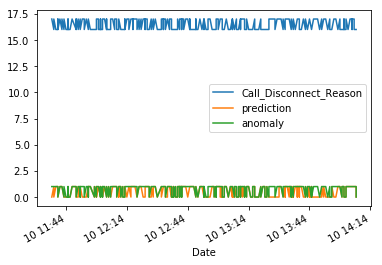

<Figure size 720x720 with 0 Axes>

In [10]:
ts = dfn
ts.plot()
plt.figure(figsize=(10,10))
plt.show()

In [11]:
import numpy as np

time_series = []
data = np.array(dfn['anomaly'])
freq = '1min'
idx = dfn.index
# Note: Setting dataframe index frequency to 1 minute requires passed values to conform to one minute
# frequency. For reference see also DataFrame.asfreq() and DataFrame.drop_duplicates()
idx.freq = pd.tseries.frequencies.to_offset(freq)
time_series.append(pd.Series(data=data, index=idx))

# Times Series Plot

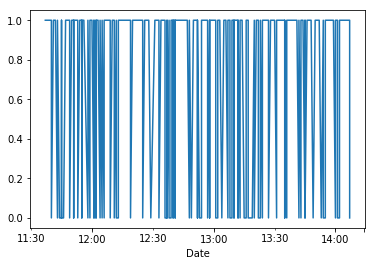

In [12]:
time_series[0].plot()
plt.show()

In [13]:
prediction_length = 20
context_length = 20
ts[:-prediction_length]

,Start_Time_MM_DD_YYYY,Start_Time_HH_MM_SS_s,Call_Disconnect_Reason,prediction,anomaly
Date,,,,,
2018-08-10 11:37:00,08/10/2018,11:37:28.1,17,0.0,1
2018-08-10 11:38:00,08/10/2018,11:37:30.1,16,1.0,1
2018-08-10 11:38:00,08/10/2018,11:37:37.1,17,0.0,1
2018-08-10 11:38:00,08/10/2018,11:38:00.1,17,0.0,1
2018-08-10 11:39:00,08/10/2018,11:38:33.1,16,1.0,1
2018-08-10 11:40:00,08/10/2018,11:39:33.1,16,1.0,1
2018-08-10 11:40:00,08/10/2018,11:39:43.1,17,0.0,1
2018-08-10 11:40:00,08/10/2018,11:39:48.1,16,0.0,0
2018-08-10 11:41:00,08/10/2018,11:41:13.1,17,1.0,1


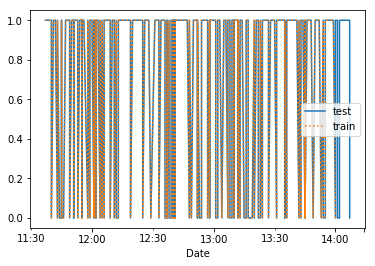

In [14]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])
time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=':')
plt.legend()
plt.show()

DeepAR supervised learning algorithm for forecasting scalar time series of Telecom Call Details Record.

In [15]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt

We will use the sagemaker client library for easy interface with sagemaker and s3fs for uploading the training data to S3. (Use `pip` to install missing libraries)

In [16]:
!conda install -y s3fs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [17]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. We use the `get_execution_role` function to obtain the role arn which was specified when creating the notebook.

In [18]:
bucket = '<%bucket_name%>' #<-- your bucket_name
version = '%%VERSION%%'
prefix = 'sagemaker/Telecom-RandomForest/DeepAR'
prefix = 'machine-learning-for-all/{}/data/cdr-stop'.format(version)  

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, we configure the container image to be used for the region that we are running in.

In [19]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Generating and uploading data

We want to train a model that can predict the next 20 points of syntheticly generated time series.
The time series that we use have minutes granularity.

We also Configure the `context_length`, which determines how much context of the time series the model should take into account when making the prediction, i.e. how many previous points to look at.

In [20]:
freq = 'min'
# we predict for 20 Minutes
prediction_length = 20

# we also use 20 Minutes as context length, this is the number of state updates accomplished before making predictions
context_length = 20

In [21]:
start_dataset = pd.Timestamp("2018-07-15 00:00:00", freq=freq)
end_training = pd.Timestamp("2018-08-09 00:00:00", freq=freq)

The following utility functions convert pandas.Series objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

In [22]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [23]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

## Train a model

We can now define the estimator that will launch the training job.

In [24]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='Ml-Telcom-DemoForecast-deepar',
    output_path="s3://" + s3_output_path
)

## Hyperparameters

In [25]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [26]:
estimator.set_hyperparameters(**hyperparameters)

SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

DeepAR will also calculate accuracy metrics for the trained model on the test data set. This is done by predicting the last `perdiction_length` points of each time series in the test set and comparing this to the actual value of the time series.


In [27]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: Ml-Telcom-DemoForecast-deepar-2018-09-27-19-04-18-999


.....................
Arguments: train
[09/27/2018 19:07:39 INFO 139992056387392] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[09/27/2018 19:07:39 INFO 139992056387392] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'dropout_rate': u'0.05', u'learning_rate': u'0.001', u'num_cells': u'40', u'prediction_length': u'20', u'epochs': u'20', u'time_freq': u'min', u'context_length': u'20', u'num_layers': u'3', u'mini_batch_size': 

[09/27/2018 19:07:45 INFO 139992056387392] Epoch[9] Batch[0] avg_epoch_loss=0.570835
[09/27/2018 19:07:45 INFO 139992056387392] Epoch[9] Batch[5] avg_epoch_loss=0.539807
[09/27/2018 19:07:45 INFO 139992056387392] Epoch[9] Batch [5]#011Speed: 691.67 samples/sec#011loss=0.539807
[09/27/2018 19:07:45 INFO 139992056387392] Epoch[9] Batch[10] avg_epoch_loss=0.531483
[09/27/2018 19:07:45 INFO 139992056387392] Epoch[9] Batch [10]#011Speed: 699.48 samples/sec#011loss=0.521493
[09/27/2018 19:07:45 INFO 139992056387392] processed a total of 343 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 557.8279495239258, "sum": 557.8279495239258, "min": 557.8279495239258}}, "EndTime": 1538075265.488624, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538075264.930735}

[09/27/2018 19:07:45 INFO 139992056387392] #throughput_metric: host=algo-1, train throughput=614.754606879 records/second
[09/27/2018 19:07:45 INFO 139992056387392] #progr


Billable seconds: 97


### Create endpoint and predictor

The model is trained , we can use it to perform predictions by deploying it to an endpoint.

In [28]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: Ml-Telcom-DemoForecast-deepar-2018-09-27-19-04-18-999
INFO:sagemaker:Creating endpoint-config with name Ml-Telcom-DemoForecast-deepar-2018-09-27-19-04-18-999
INFO:sagemaker:Creating endpoint with name Ml-Telcom-DemoForecast-deepar-2018-09-27-19-04-18-999


---------------------------------------------------------------------------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [29]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [30]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

### Make predictions and plot results

Now we can use the previously created `predictor` object. For simplicity, we will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

In [31]:
list_of_df = predictor.predict(time_series_training[:10])
actual_data = time_series[:10]

In [32]:
prediction_length = 10
context_length = 10

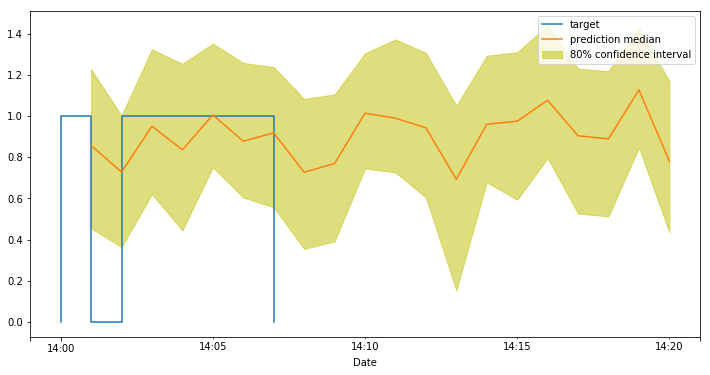

In [33]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

### Delete endpoint

In [34]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: Ml-Telcom-DemoForecast-deepar-2018-09-27-19-04-18-999
